In [23]:
#memo:@vectorize is used to write an expression that can be applied one element at a time (scalars) to an array. 
#The @jit decorator is more general and can work on any type of calculation. 
from numba import cuda
import numpy as np
import math

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
from numba import vectorize, int64, float32, int16, cuda

@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_log(x):
    c =  np.log(x)
    return c

A = vec_log(np.float32([2,5,10,3,8]))
print('Log:',A)
##############################################################################
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_exp(x):
    c =  np.exp(x)
    return c

A = vec_exp(np.float32([2,5,10,3,8]))
 
print('Exp:',A)

Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
import numpy as np
from numba import vectorize, int64, float32, int16, cuda

@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def gauss(x):
    sigma = 1
    mean  = 1
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)
#devo specificarlo il dtype
x = np.linspace(-3, 3, 100000, dtype='float32')
gauss(x)

array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400392, 0.05399745,
       0.05399097], dtype=float32)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

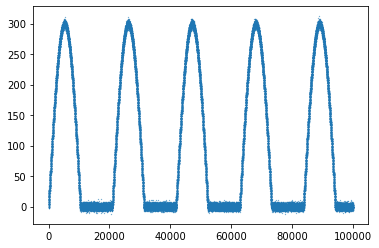

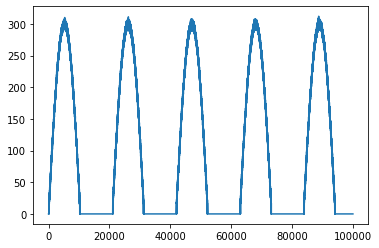

In [67]:
n = 100000
c=(n/30) 
noise = np.random.normal(loc=0.0, scale=1.0, size=n) * 3
#l'output è da zero in poi, escludo il semiasse negativo con np.maximum
out_put = (np.maximum( np.sin(np.arange(n)/c), 0.0 )* 300 + noise).astype(np.int16)

plt.plot(out_put,'.',markersize=0.5) 
plt.show()
##############################################################
@vectorize([int16(int16)], target='parallel', fastmath=True)
def zero_suppression(x):
    if x < 15:
        return 0
    else:
        return x
out_put_suppressed = zero_suppression(out_put)
plt.plot(out_put_suppressed)

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
import math
n = 3
#variable's inizialization
x = np.random.rand(n,n).astype('float32')
y = np.random.rand(n,n).astype('float32')
k = np.zeros((n,n), dtype='float32')

@cuda.jit
def sigmoid_kernel(x,y,k,alpha,c):    
    row, col = cuda.grid(2)
    if row < k.shape[0] and col < k.shape[1]:
        tmp = 0.
        for i in range(0,x.shape[0]):
            tmp = tmp + x[i, row] * y[i, col]           
        k[row, col] = math.tanh(alpha * tmp + c)
        
#kernel
sigmoid_kernel[(1,1), (3,3)](x, y, k, 1., 1.)

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [33]:
# CUDA kernel
@cuda.jit
def cos_kernel_3D(v):
    row, col, l = cuda.grid(3)
    if row < v.shape[0] and col < v.shape[1] and l < v.shape[2]:
        # do the computation
        v[row][col][l] *= math.cos(v[row][col][l]) 

# 256𝑋256𝑋256 matrix:
x = np.random.normal(size=(256,256,256))

# Configure the blocks, CUDA'S doc
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#calculating the 𝑐𝑜𝑠 for each element of x
cos_kernel_3D[blockspergrid, threadsperblock](x)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [24]:
# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B"""
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# (modo più rapido per inizializzare A e B)
A = np.random.randint(100, size=(24,12))
B = np.random.randint(100, size=(12,22))

# Configure the blocks, CUDA'S doc
threadsperblock = (24, 22)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

#C's inizialization 
C = np.zeros((24,22))

#Matrix multiplication kernel function
matmul[blockspergrid, threadsperblock](A, B, C)